# COGS 108 - Final Project 

# Overview

This project is intended to find the relationship between expenditures and the given fund type that it is alloted to in the San Diego Parks and Recreation Budget. The data, and a linear regression, lead me to believe that there is a negative correlation between the different fund types and the expenditure amount. 

# Name & GitHub

- Name: Brandon Giang
- GitHub Username: KawaiiLemon

# Research Question

Is there a relationship between expenditures and fund types in the San Diego Parks and Recreation Budget?

## Background and Prior Work

The government divides their funds into many different subjects to keep their money organized. In this project we will only be looking at four of these specifically, the general, special revenue, capital project, and enterprise funds.

The general fund is for money that is not associated with special purposes. The special revenue fund are for purposes that raise money for specific projects. Capital project funds are for building capital facilities. Lastly, enterprise funds are for supporting the government by selling goods and services to the public. 

These four funds are what make up the Parks and Recreation budget.

References (include links):
- 1) https://www.investopedia.com/terms/s/special-revenue-fund.asp
- 2) https://www.lawinsider.com/dictionary/capital-projects-fund
- 3) https://www.accountingtools.com/articles/2017/5/9/general-fund
- 4) https://www.accountingtools.com/articles/2017/5/6/enterprise-fund

# Hypothesis


I hypothesize that there is a relationship between the different fund types and their expenditures. Capital facilities can be very expensive in their building and land costs. General funds can be expensive, however, I believe that, in general, the funds can reach very small numbers for menial purchases. The same can be said about the other two funds, as I am sure that marketing and services could very well have their own price ranges. 

# Dataset(s)

- Dataset Name: San Diego Budget Data
- Link to the dataset: https://data.sandiego.gov/datasets/operating-actuals/
- Number of observations: 454,891

This dataset displays information regarding funds of San Diego county, specifically what funds are distributed and collected for specific departments and fund types. Other information includes fund center indentifier numbers and the function of the funds.

# Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest

import matplotlib.pyplot as plt


df = pd.read_csv('../data/actuals_operating_datasd.csv')

# Data Cleaning

Let's look at all the departments in the San Diego budget data.

In [2]:
df['dept_name'].unique()

array(['Office of the Chief Operating Officer', 'Council District 1',
       'Council District 2', 'Council District 3', 'Council District 4',
       'Council District 5', 'Council District 6', 'Council District 7',
       'Council District 8', 'Council District 9',
       'Council Administration', 'City Clerk',
       'Independent Budget Analyst', 'City Attorney', 'Personnel',
       'Ethics Commission', 'Office of the City Auditor',
       'Assistant Chief Operating Officer', 'Performance & Analytics',
       'Human Resources', 'Department of Information Technology',
       'Economic Development', 'Internal Operations',
       'Office of the Mayor', 'Communications', 'Chief Financial Officer',
       'City Comptroller', 'Debt Management', 'Financial Management',
       'Purchasing & Contracting', 'City Treasurer',
       'Smart & Sustainable Communities', 'Development Services',
       'Real Estate Assets', 'Planning', 'Library', 'Parks & Recreation',
       'Fire-Rescue', 'Police', 

Here, we only need the financial information for the Parks and Recreation Department, so modifying as necessary, we have budget information only pertaining to Parks and Recreation.

In [3]:
df_parks = df[df['dept_name'] == 'Parks & Recreation']

df_parks.head()

,amount,report_fy,fund_type,fund_number,dept_name,funds_center_number,account,account_number
8111,75.52,17,General Fund,100000,Parks & Recreation,1714110001,Graffitti Control Restitution,417024
8112,156.84,17,General Fund,100000,Parks & Recreation,1714110001,Repair Damages Recovered,423106
8113,-6478.12,17,General Fund,100000,Parks & Recreation,1714110001,Salaried Wages,500011
8114,-188.86,17,General Fund,100000,Parks & Recreation,1714110001,Supp Pens Sav Plan Mandatory,502021
8115,-181.19,17,General Fund,100000,Parks & Recreation,1714110001,Supp Pens Sav Plan Voluntary,502022


Next, we only care about the expenditures, so we remove all positive numbers from the amount column since positive indicates we gain money for the budget. We also look at if there are any null values that can possibly disrupt the process and remove them.

In [4]:
df_parks = df_parks[df_parks['amount'] < 0]
nan = df_parks.isna().sum()
print(nan)

df_parks.head()

amount                 0
report_fy              0
fund_type              0
fund_number            0
dept_name              0
funds_center_number    0
account                0
account_number         0
dtype: int64


,amount,report_fy,fund_type,fund_number,dept_name,funds_center_number,account,account_number
8113,-6478.12,17,General Fund,100000,Parks & Recreation,1714110001,Salaried Wages,500011
8114,-188.86,17,General Fund,100000,Parks & Recreation,1714110001,Supp Pens Sav Plan Mandatory,502021
8115,-181.19,17,General Fund,100000,Parks & Recreation,1714110001,Supp Pens Sav Plan Voluntary,502022
8116,-48.37,17,General Fund,100000,Parks & Recreation,1714110001,Fica/Medicare Insurance,502051
8278,-6165.43,17,General Fund,100000,Parks & Recreation,1714111111,P-Card Unallocated Expense (Comptroller Use Only),516046


We also should get rid of some extra information not really useful to us, like the report_fy, funds_center_number, and other extraneous idenfier numbers.

In [5]:
df_parks = df_parks.drop(['report_fy', 'funds_center_number', 'account_number', 'fund_number'], axis=1)

df_parks.head()

,amount,fund_type,dept_name,account
8113,-6478.12,General Fund,Parks & Recreation,Salaried Wages
8114,-188.86,General Fund,Parks & Recreation,Supp Pens Sav Plan Mandatory
8115,-181.19,General Fund,Parks & Recreation,Supp Pens Sav Plan Voluntary
8116,-48.37,General Fund,Parks & Recreation,Fica/Medicare Insurance
8278,-6165.43,General Fund,Parks & Recreation,P-Card Unallocated Expense (Comptroller Use Only)


Here, I don't consider this specific amount below an expenditure because of the account details, so I will be removing all rows with this account description.

In [6]:
df_acc = df_parks[df_parks['account'] == 'Transfers To Other Funds']

df_acc.head()

,amount,fund_type,dept_name,account
106443,-203117.0,General Fund,Parks & Recreation,Transfers To Other Funds


In [7]:
df_parks = df_parks.drop(106443, axis=0)

df_acc = df_parks[df_parks['account'] == 'Transfers To Other Funds']

df_acc.head()

,amount,fund_type,dept_name,account


Lastly, we want to change amount to positive numbers as they are easier to look at on a graph and we know that all these current amounts are expenditures.

In [8]:
df_parks['amount'] = df_parks['amount'] * -1

df_parks.head()

,amount,fund_type,dept_name,account
8113,6478.12,General Fund,Parks & Recreation,Salaried Wages
8114,188.86,General Fund,Parks & Recreation,Supp Pens Sav Plan Mandatory
8115,181.19,General Fund,Parks & Recreation,Supp Pens Sav Plan Voluntary
8116,48.37,General Fund,Parks & Recreation,Fica/Medicare Insurance
8278,6165.43,General Fund,Parks & Recreation,P-Card Unallocated Expense (Comptroller Use Only)


# Data Analysis & Results

Here, we'll take account of what kinds of funds and how many we have of each.

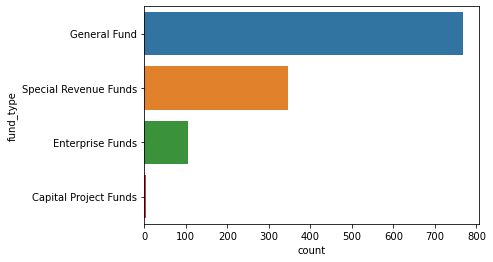

In [9]:
sns.countplot(y='fund_type', data=df_parks)

Figure 1: Looks like there is a massive difference in the amount of funds from one to another (doubling from bottom to top).

<ipython-input-10-3c229e0551c0>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.distplot(df_parks[df['fund_type'] == 'General Fund']['amount'], kde=False)


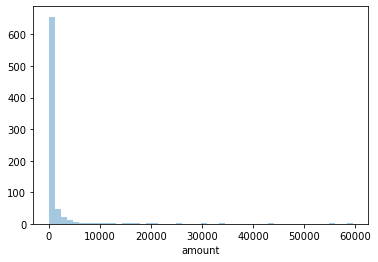

In [10]:
sns.distplot(df_parks[df['fund_type'] == 'General Fund']['amount'], kde=False)

Figure 2: Many of the general fund expenditures have small values, but has a massive range.

<ipython-input-11-c5106cd0faa7>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.distplot(df_parks[df['fund_type'] == 'Special Revenue Funds']['amount'], kde=False)


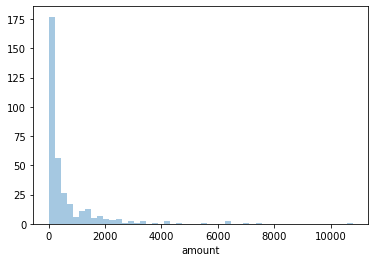

In [11]:
sns.distplot(df_parks[df['fund_type'] == 'Special Revenue Funds']['amount'], kde=False)

Figure 3: The special revenue expenditures has less range than the general.

<ipython-input-12-fa1c3fcc8f34>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.distplot(df_parks[df['fund_type'] == 'Enterprise Funds']['amount'], kde=False)


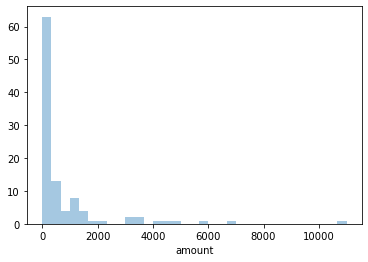

In [12]:
sns.distplot(df_parks[df['fund_type'] == 'Enterprise Funds']['amount'], kde=False)

Figure 4: The Enterprise funds seem to have similaar results as the special revenue, but there are less values to consider.

<ipython-input-13-008613155728>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.distplot(df_parks[df['fund_type'] == 'Capital Project Funds']['amount'], kde=False)


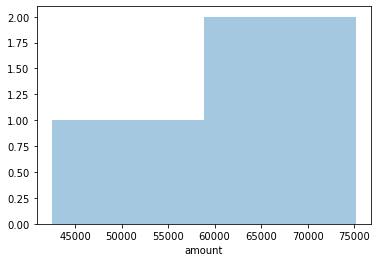

In [13]:
sns.distplot(df_parks[df['fund_type'] == 'Capital Project Funds']['amount'], kde=False)

Figure 5: There are only three captial project fund expenditures, so it is hard to get any association or prediction of correlation.

In [14]:
# In order to use boxcox transformation, must turn h_g, etc. into ndarrays then run the commented code, but I refrained
# from using boxcox because I does not seem like it will at all help my interpretation if I make the data look like a 
# normal distribution.

h_g = df_parks[df_parks['fund_type'] == 'General Fund']['amount'].values
h_sr = df_parks[df_parks['fund_type'] == 'Special Revenue Funds']['amount'].values
h_e = df_parks[df_parks['fund_type'] == 'Enterprise Funds']['amount'].values

#h_g = stats.boxcox(h_g)
#h_sr = stats.boxcox(h_sr)
#h_e = stats.boxcox(h_e)

#h_g = np.take(h_g, 0)
#h_sr = np.take(h_sr, 0)
#h_e = np.take(h_e, 0)

#g = pd.Series(h_g)
#sr = pd.Series(h_sr)
#e = pd.Series(h_e)

In [15]:
p_g = normaltest(h_g).pvalue
p_sr = normaltest(h_sr).pvalue
p_e = normaltest(h_e).pvalue

print(p_g)
print(p_sr)
print(p_e)

3.11023761638101e-253
2.6590830108353187e-73
2.5648072075949475e-24


These values are far than a normal distribution. There is the option to transform it to normal using box cox (other methods like using log would not work), but it would ultimately change the data and would make it haard to analyze.

In [16]:
outcome_1, predictors_1 = patsy.dmatrices('amount ~ fund_type', df_parks)
mod_1 = sm.OLS(outcome_1, predictors_1)
res_1 = mod_1.fit()

print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:                 amount   R-squared:                       0.422
Model:                            OLS   Adj. R-squared:                  0.420
Method:                 Least Squares   F-statistic:                     295.8
Date:                Wed, 16 Dec 2020   Prob (F-statistic):          3.76e-144
Time:                        13:08:25   Log-Likelihood:                -11717.
No. Observations:                1220   AIC:                         2.344e+04
Df Residuals:                    1216   BIC:                         2.346e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

Figure 6: Here, it looks like there is some sort of negative correlation of fund_type to the amount spent. However, the data is not normally distributed (as assumed), so this data is potentially interpretted incorrectly. Additionally, there is large large standard error, so it may be hard to pinpoint if this regression is completely accurate.

# Ethics & Privacy

This is public government budget data and a dataset given to me, so I have been given permission to use this dataset for my analytic purposes. There is a chance that I may overlook aspects of this data because I have ignored parts of this dataset.

This data could be misinterpreted in where the parks should cut their expenses. While it seems that there is a correlation, there is a lot more data pertaining to certain funds. The general fund has way more data compared to the other funds. 

Additionally, the captial projects fund only has three expenditures. There are not enough of these to analyze fully.

# Conclusion & Discussion

This project was intended to find the relationship between the fund types and their expenditures. While it does seems like there is a negative correlation of different funds to expenditures, the data was not normally distributed and the standard error was large. There was a way for me to make the data normally distributed using hte boxcox transformation, but it would change the data to be misinterpreted greatly.

Another limitation of this project was the limited dataset size. There was more than double data for the General Fund than all the other funds. Additionally, the capital projects fund only had about three expenditures, which did not allow for an accurate prediction. 

Overall, there seems to be a negative correlation of the data using a linear regression and may help with pinpointing where money is being drained from, however the correlation may not be all accurate as it uses a limited dataset and a most likely inaccurate regression.